## TwoStep
This method will use a **2-step method** for **positive-unlabeled** classifier learning [(Kaboutari, et al. 2014)](https://www.semanticscholar.org/paper/An-Evaluation-of-Two-Step-Techniques-for-Learning-Kaboutari-Bagherzadeh/bd10ba5f30744e4755cbe7757e8c657ce5d6ec45)
1. Choose datapoints (droplets) that are confidently positive for the given label (in our case, empty droplets and dead cells)
2. Use some method of determining datapoints (droplets) that are confidently negative for the given label (we can use UMI ranking and MT enrichment of clusters)

In [1]:
from QC import *
sc.settings.set_figure_params(dpi=80)

### Load data and preprocess

Read in normal human colon sample

In [2]:
%time s1 = sc.read_h5ad('data/3247-AS-1-GCCAAT_S1_labeled.h5ad')

CPU times: user 8.13 s, sys: 1.42 s, total: 9.55 s
Wall time: 9.54 s


In [3]:
s1 # see what's in our object

AnnData object with n_obs × n_vars = 19128 × 41569 
    obs: 'mean_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'label'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Find inflection point

Inflection point at index
bcEGRW     3541
bcGOPG     5895
bcFVGH     8972
bcGJKY    13918
bcDZKU    19127
Name: total_counts, dtype: int64 for [0, 20, 40, 70, 100] percentiles of greatest secant distances


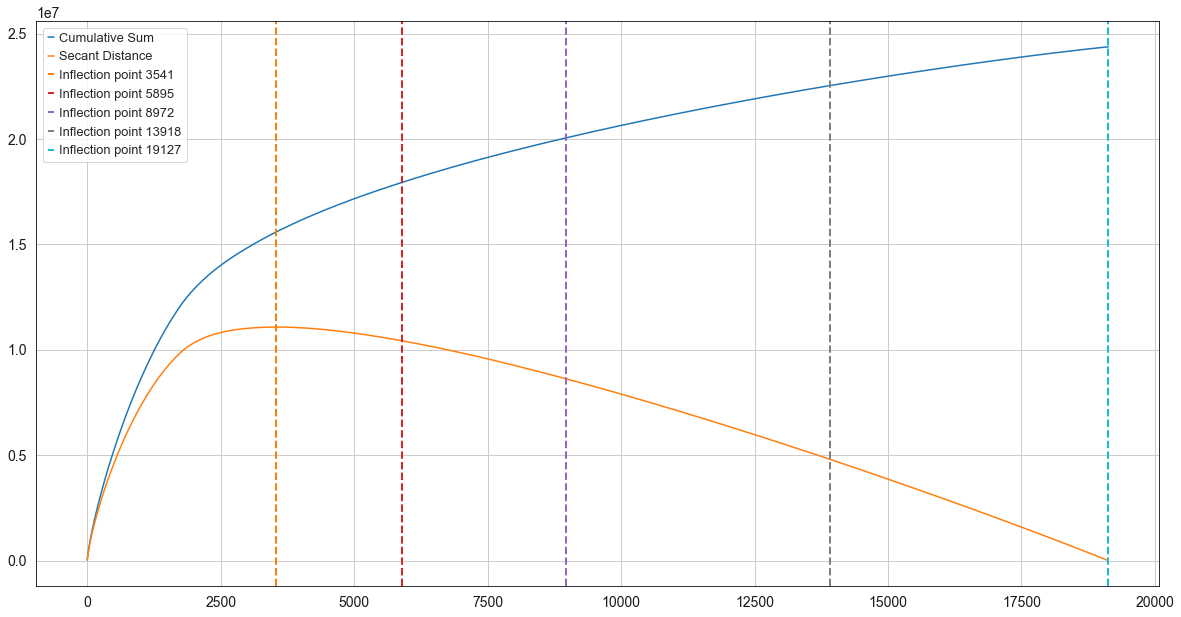

In [4]:
find_inflection(s1, inflection_percentiles = [0,20,40,70,100])

In [5]:
s1.obs['total_counts'][13918] # see the total counts at 80th percentile of secant distance (beyond inflection point)

424.0

In [6]:
s1.obs['total_counts'][3541] # see the total counts at inflection point

1275.0

In [7]:
# create new "observation" as empty droplet label
s1.obs['twostep_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][13918], 1, -1) # 1 is empty, -1 is unlabeled
s1.obs.loc[s1.obs['ranked_total_counts']>=s1.n_obs*0.97, 'twostep_empty'] = 0 # take top 3% of dataset by total UMI counts and add as "not empty"

In [8]:
s1.obs['twostep_empty'].value_counts()

-1    13345
 1     5210
 0      573
Name: twostep_empty, dtype: int64

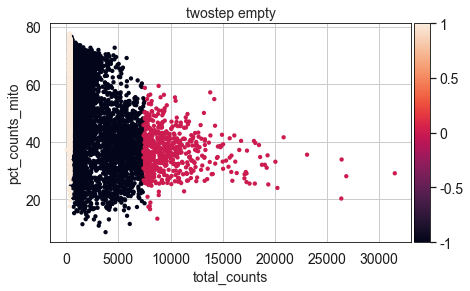

In [9]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='twostep_empty', size=75)

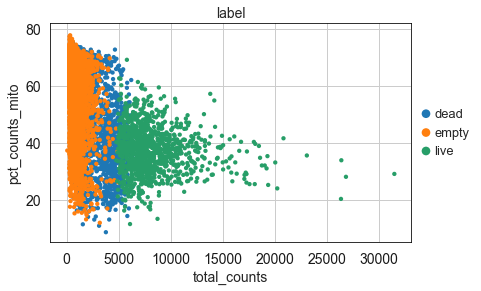

In [10]:
# look at our previously-defined labels
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='label', size=75)

### Normalize and perform linear dimensionality reduction with PCA
Principal components will be fed into classifiers to speed up processing time by reducing gene dimensions to 100 from 40k+.

In [11]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p transformation
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 5.07 s, sys: 819 ms, total: 5.89 s
Wall time: 5.9 s


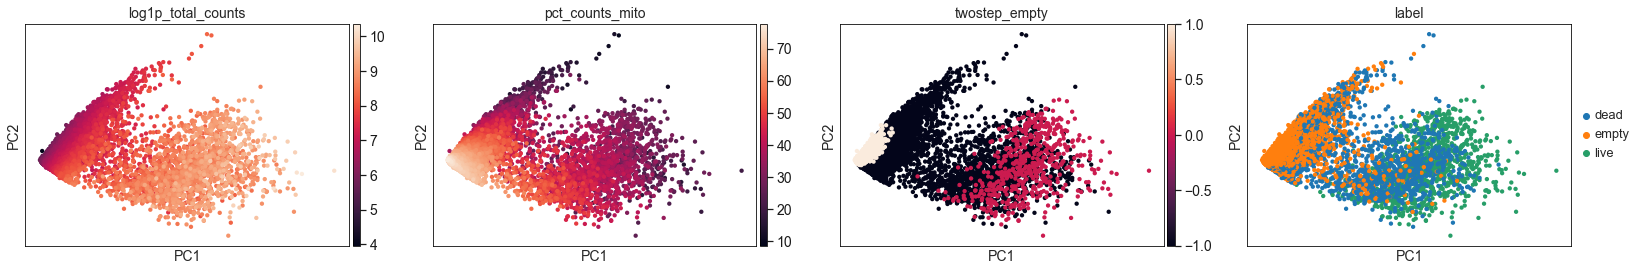

CPU times: user 1min 55s, sys: 5.65 s, total: 2min
Wall time: 23.7 s


In [12]:
%%time
sc.tl.pca(s1, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1, color=['log1p_total_counts','pct_counts_mito','twostep_empty','label'], ncols=4, size=75)

In [131]:
# reload fcc module while working
import sys
del sys.modules['PU_twostep']
from PU_twostep import *

In [134]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['twostep_empty'].copy(deep=True) # training labels are from .obs df

In [135]:
%%time
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1) # define random forest classifier, you can plug in any classifier though!
scores_twostep_empty, labels_twostep_empty = twoStep(clf=rf, X=X, y=y, n_iter=18)

Step 1 labeled 3537 new positives and 109 new negatives.
Iteration 1: Doing step 2... Step 1 labeled 171 new positives and 69 new negatives.
Iteration 2: Doing step 2... Step 1 labeled 62 new positives and 32 new negatives.
Iteration 3: Doing step 2... Step 1 labeled 37 new positives and 16 new negatives.
Iteration 4: Doing step 2... Step 1 labeled 20 new positives and 21 new negatives.
Iteration 5: Doing step 2... Step 1 labeled 16 new positives and 32 new negatives.
Iteration 6: Doing step 2... Step 1 labeled 27 new positives and 29 new negatives.
Iteration 7: Doing step 2... Step 1 labeled 32 new positives and 21 new negatives.
Iteration 8: Doing step 2... Step 1 labeled 46 new positives and 32 new negatives.
Iteration 9: Doing step 2... Step 1 labeled 68 new positives and 20 new negatives.
Iteration 10: Doing step 2... Step 1 labeled 21 new positives and 19 new negatives.
Iteration 11: Doing step 2... Step 1 labeled 12 new positives and 16 new negatives.
Iteration 12: Doing step 2.

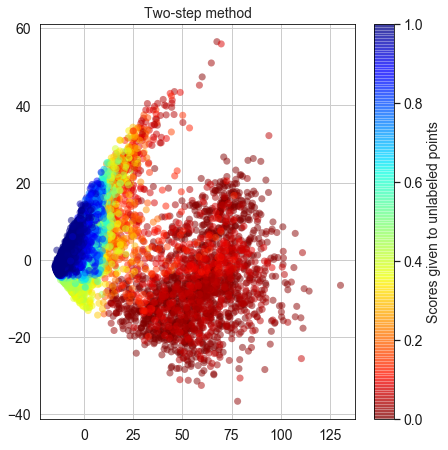

In [136]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = scores_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

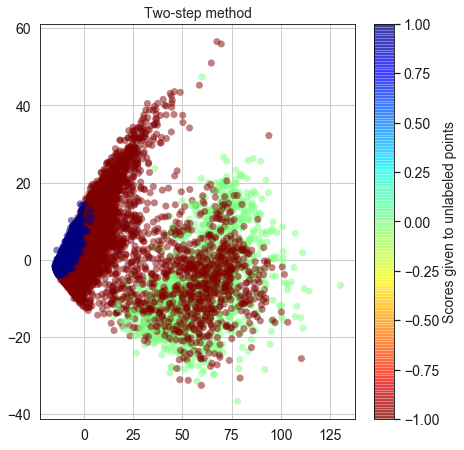

In [137]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = labels_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

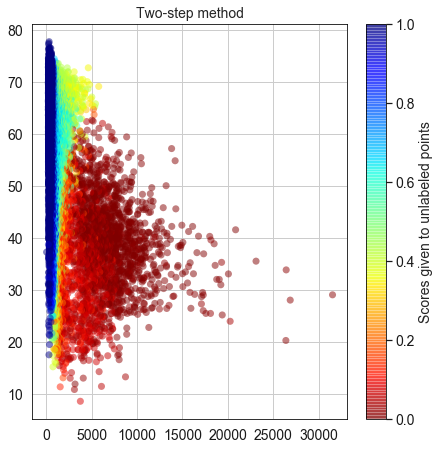

In [138]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = scores_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

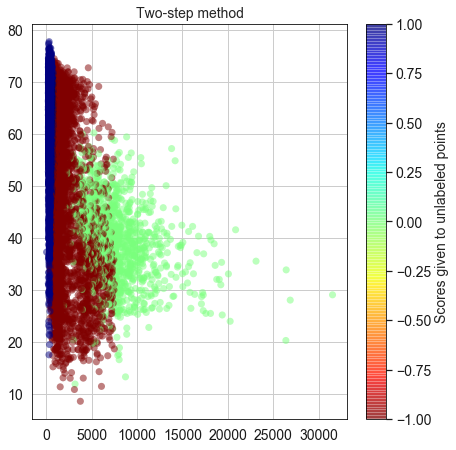

In [139]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = labels_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()